<a href="https://colab.research.google.com/github/YeyoM/Time_Series_Forecast_ML/blob/main/Forecasting_using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time windows

This is part 2 of the "Forecasting time series with ML". The first notebook to understand what a time series is can be found [here](https://colab.research.google.com/drive/1I-dqb6V-2LghIb5a-kkAtaQpl5UI7f-s?usp=sharing).

Using machine learning for forecast functions by giving the model a time window (period of time of the time series) and what it returns us is the next time-step of the series.

![](https://drive.google.com/uc?export=view&id=1r5Bs2kyInT0jQ7hk-bd38Wtmxcz9SNJ3)



### How can we implement time series in tensorflow?

Lets look at an example. 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

First, we will take a look at every little step, so then we can build all these steps into a single function.

In [ ]:
# Generate a time series of 10 values
dataset = tf.data.Dataset.range(10)

In [ ]:
# Generate the windows of the dataset 
# 5 fixed elementes each window
dataset = dataset.window(5, shift = 1, drop_remainder = True)

In [ ]:
# We flatten the dataset and take the 5 elements we want for every window
dataset = dataset.flat_map(lambda window: window.batch(5))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
# We divide each window into two
# The first ones will be the inputs for the model
# The second one will be the labels
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [ ]:
# We shuffle the windows
dataset = dataset.shuffle(buffer_size=10)

In [ ]:
# As when training a ml model, we take batches, in this case of 2
dataset = dataset.batch(2).prefetch(1)

In [ ]:
# Lets see the results
for x, y in dataset:
    print("x =", x.numpy())
    print("y =", y.numpy())

x = [[5 6 7 8]
 [2 3 4 5]]
y = [[9]
 [6]]
x = [[1 2 3 4]
 [3 4 5 6]]
y = [[5]
 [7]]
x = [[4 5 6 7]
 [0 1 2 3]]
y = [[8]
 [4]]


In [ ]:
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Building a model

First we will add some functions viewed on the previous colab notebook to create a fake time series.

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

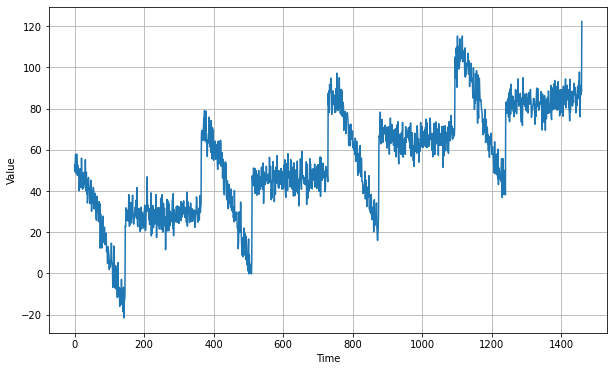

In [ ]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

This model will forecast the next step given the previous 30 steps, therefore, we will create a dataset of 30-step window for training.

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Linear Model

This will be a linear regression model with only one layer, and since we want to forecast a single value we just need a single unit.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_shape=[window_size])
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-5, momentum = 0.9)
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

In [ ]:
history = model.fit(train_set, epochs = 100, validation_data = valid_set, callbacks = [early_stopping])

Epoch 1/100
31/31 [==============================] - 0s 5ms/step - loss: 4.9309 - mae: 5.4103 - val_loss: 5.1207 - val_mae: 5.5994
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 4.9320 - mae: 5.4118 - val_loss: 5.4543 - val_mae: 5.9383
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 4.9794 - mae: 5.4581 - val_loss: 5.3564 - val_mae: 5.8361
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 5.0208 - mae: 5.5033 - val_loss: 5.0818 - val_mae: 5.5604
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 4.8691 - mae: 5.3460 - val_loss: 5.0725 - val_mae: 5.5492
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 4.8390 - mae: 5.3159 - val_loss: 5.6039 - val_mae: 6.0879
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 4.8609 - mae: 5.3382 - val_loss: 5.1197 - val_mae: 5.6079
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 4.8805 - m

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 5ms/step


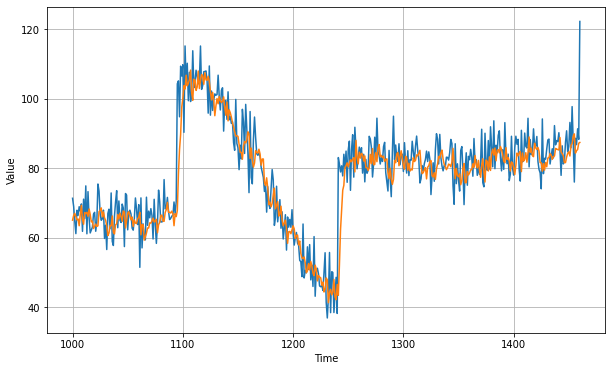

In [ ]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

4.9278812

## Dense Model

Lets try now a similar approach, but with a dense model.



In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape = [window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-5, momentum = 0.9)
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

In [ ]:
model.fit(
    train_set, 
    epochs = 500,
    validation_data = valid_set,
    callbacks = [early_stopping]
)

Epoch 1/500
31/31 [==============================] - 1s 10ms/step - loss: 34.1086 - mae: 34.6047 - val_loss: 20.5874 - val_mae: 21.0856
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 8.9309 - mae: 9.4198 - val_loss: 6.9672 - val_mae: 7.4514
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 7.2025 - mae: 7.6825 - val_loss: 6.4738 - val_mae: 6.9634
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 6.8095 - mae: 7.2944 - val_loss: 6.1593 - val_mae: 6.6404
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 6.4614 - mae: 6.9455 - val_loss: 6.0734 - val_mae: 6.5568
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 6.2481 - mae: 6.7309 - val_loss: 5.8827 - val_mae: 6.3636
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 6.0613 - mae: 6.5426 - val_loss: 5.6333 - val_mae: 6.1099
Epoch 8/500
31/31 [==============================] - 0s 4ms/step - loss: 5.951

In [ ]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 4ms/step


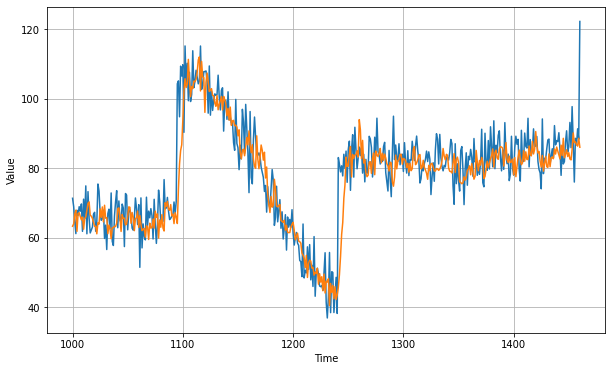

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.281962